In [1]:
%matplotlib inline
import torch as tc
import tensorflow as tf
import mxnet as mx
from mxnet import np as mxnp
from mxnet import npx as npx
npx.set_np()
# import numpy as np

from d2l import mxnet as mxd2l  # Use MXNet as the backend
from d2l import torch as tcd2l  # Use PyTorch as the backend
from d2l import tensorflow as tfd2l  # Use TensorFlow as the backend

tc.__version__,tf.__version__,mx.__version__

('1.6.0', '2.3.1', '1.7.0')

In [2]:
from mxnet import gluon
from mxnet.gluon import nn

https://d2l.ai/chapter_recurrent-modern/gru.html

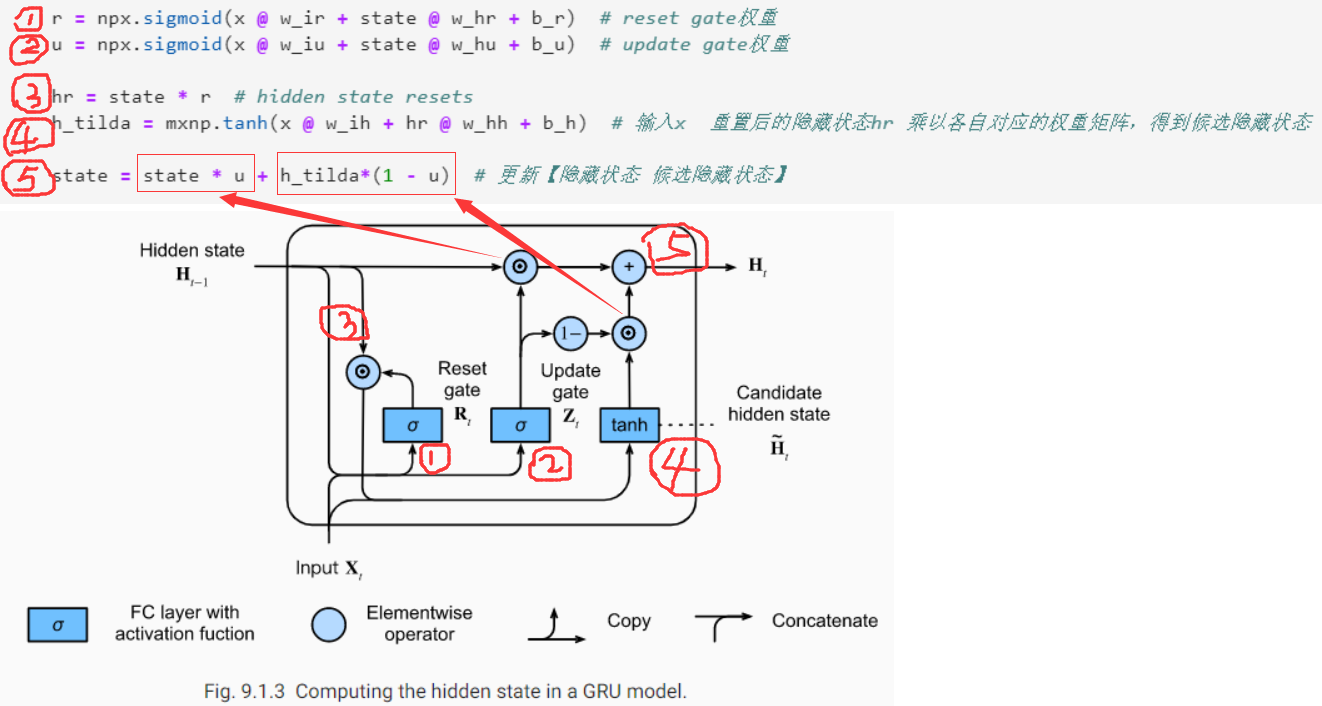

In [9]:
class GruScratch:
    def __init__(self, num_inputs, num_hiddens, num_outputs, ctx=mxd2l.try_gpu(),output_type=1):
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.num_outputs = num_outputs
        self.ctx = ctx

        self.i_shape = (num_inputs, num_hiddens)
        self.h_shape = (num_hiddens, num_hiddens)
        self.o_shape = (num_hiddens, num_outputs)

        self.params = self._params_init(ctx=self.ctx)
        self.output_type=output_type

    def _w_normal_init(self, shape, ctx, scale=0.01):
        return mxnp.random.normal(size=shape,scale=scale, ctx=ctx, dtype=mxnp.float32)

    def _params_init(self, ctx):
        w_ih = self._w_normal_init(self.i_shape, ctx=ctx)
        w_ir = self._w_normal_init(self.i_shape, ctx=ctx)
        w_iu = self._w_normal_init(self.i_shape, ctx=ctx)

        w_hh = self._w_normal_init(self.h_shape, ctx=ctx)
        w_hr = self._w_normal_init(self.h_shape, ctx=ctx)
        w_hu = self._w_normal_init(self.h_shape, ctx=ctx)

        b_h = mxnp.zeros(shape=self.num_hiddens, dtype=mxnp.float32, ctx=ctx)
        b_r = mxnp.zeros(shape=self.num_hiddens, dtype=mxnp.float32, ctx=ctx)
        b_u = mxnp.zeros(shape=self.num_hiddens, dtype=mxnp.float32, ctx=ctx)

        w_ho = self._w_normal_init(self.o_shape, ctx=ctx)
        b_o = mxnp.zeros(shape=self.num_outputs, dtype=mxnp.float32, ctx=ctx)

        params = [w_ih, w_ir, w_iu, w_hh, w_hr, w_hu, b_h, b_r, b_u, w_ho, b_o]
        for param in params:
            param.attach_grad()
        return params

    def _process_input(self, x, state, ctx):
        assert len(x.shape) == 2, f"x输入的要求是2D，但实际的x.shape={x.shape}"
        batch_size = x.shape[0]
        x = x.T
        x = npx.one_hot(x, self.num_inputs)

        if state is None:
            state = self.begin_state(batch_size, ctx)
        x=x.as_in_ctx(ctx)
        return x, state

    def begin_state(self, batch_size, ctx):
        state = self._w_normal_init(shape=(batch_size, self.num_hiddens), ctx=ctx)
        return (state,)

    def forward(self, X, state):
        w_ih, w_ir, w_iu, w_hh, w_hr, w_hu, b_h, b_r, b_u, w_ho, b_o = self.params
        state = state[0]
        outputs = []
        for x in X:
            r = npx.sigmoid(x @ w_ir + state @ w_hr + b_r)  # reset gate权重
            u = npx.sigmoid(x @ w_iu + state @ w_hu + b_u)  # update gate权重

            hr = state * r  # hidden state resets
            h_tilda = mxnp.tanh(x @ w_ih + hr @ w_hh + b_h)  # 输入x  重置后的隐藏状态hr 乘以各自对应的权重矩阵，得到候选隐藏状态

            #state = state * u + h_tilda*(1 - u)  # 更新【隐藏状态 候选隐藏状态】
            
            state=h_tilda  # 注释了上面的更新门，仅保留了reset门，看看训练效果如何！
            
            y = state @ w_ho + b_o  # 计算输出
            outputs.append(y)
        return mxnp.concatenate(outputs, axis=0), (state,)

    def gru(self, inputs, state, params):
        w_ih, w_ir, w_iu, w_hh, w_hr, w_hu, b_h, b_r, b_u, w_ho, b_o = params
        W_xz=w_iu
        W_hz=w_hu
        b_z=b_u
        W_xr=w_ir
        W_hr=w_hr
        b_r=b_r
        W_xh=w_ih
        W_hh=w_hh
        b_h=b_h
        W_hq=w_ho
        b_q = b_o

        H, = state
        outputs = []
        np=mxnp
        for X in inputs:
            Z = npx.sigmoid(np.dot(X, W_xz) + np.dot(H, W_hz) + b_z)
            R = npx.sigmoid(np.dot(X, W_xr) + np.dot(H, W_hr) + b_r)
            H_tilda = np.tanh(np.dot(X, W_xh) + np.dot(R * H, W_hh) + b_h)
            H = Z * H + (1 - Z) * H_tilda
            Y = np.dot(H, W_hq) + b_q
            outputs.append(Y)
        return np.concatenate(outputs, axis=0), (H,)

    def __call__(self, x, state):
        output_type=self.output_type
        X, state = self._process_input(x, state, self.ctx)
        if output_type==1: 
            out1, state1 = self.forward(X, state)
            return out1,state1 # 训练用

        

## test

batch_size,num_inputs, num_hiddens, num_outputs = 2 , 28 , 32 , 1
gru=GruScratch(num_inputs, num_hiddens, num_outputs,output_type=1)
x=mxnp.arange(10).reshape(batch_size,-1)
h=gru.begin_state(batch_size,gru.ctx)
print(x.shape,h[0].shape)
o1,h1=gru(x,h)
print("end")

(2, 5) (2, 32)
end


perplexity 9.9, 15914.7 tokens/sec on gpu(0)
time traveller an the the the the the the the the the the the th
traveller an the the the the the the the the the the the th


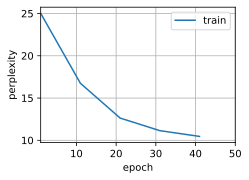

In [10]:
batch_size, num_steps = 32, 35
train_iter, vocab = mxd2l.load_data_time_machine(batch_size, num_steps)

vocab_size, num_hiddens, device = len(vocab), 25, mxd2l.try_gpu()
num_inputs=num_outputs=vocab_size
gru=GruScratch(num_inputs, num_hiddens, num_outputs,output_type=1)

num_epochs, lr = 50, 1
mxd2l.train_ch8(gru, train_iter, vocab, lr, num_epochs, device)

perplexity 1.1, 14290.3 tokens/sec on gpu(0)
time travelleryou can show black is white by argument said filby
traveller for so it will be convenient to speak of himwas e


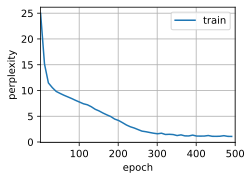

In [11]:
batch_size, num_steps = 32, 35
train_iter, vocab = mxd2l.load_data_time_machine(batch_size, num_steps)

vocab_size, num_hiddens, device = len(vocab), 128, mxd2l.try_gpu()
num_inputs=num_outputs=vocab_size
gru=GruScratch(num_inputs, num_hiddens, num_outputs,output_type=1)

num_epochs, lr = 500, 1
mxd2l.train_ch8(gru, train_iter, vocab, lr, num_epochs, device)